Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Try other [scikit-learn scalers](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```



In [24]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge
 * branch            master     -> FETCH_HEAD
Already up to date.


In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

###quick overview of data

In [26]:
train.head()

id  amount_tsh  ... waterpoint_type_group    status_group
0  69572      6000.0  ...    communal standpipe      functional
1   8776         0.0  ...    communal standpipe      functional
2  34310        25.0  ...    communal standpipe      functional
3  67743         0.0  ...    communal standpipe  non functional
4  19728         0.0  ...    communal standpipe      functional

[5 rows x 41 columns]

In [27]:
sample_submission.head()

id status_group
0  50785   functional
1  51630   functional
2  17168   functional
3  45559   functional
4  49871   functional

###train/validate/test/split

In [45]:
from sklearn.model_selection import train_test_split
# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

###Clean outliers and engineer features.

In [31]:
import pandas_profiling
train.profile_report()

In [32]:

#descriptive analysis of data
train.describe(include='all')

id     amount_tsh  ... waterpoint_type_group status_group
count   47520.000000   47520.000000  ...                 47520        47520
unique           NaN            NaN  ...                     6            3
top              NaN            NaN  ...    communal standpipe   functional
freq             NaN            NaN  ...                 27642        25807
mean    37037.915699     321.925261  ...                   NaN          NaN
std     21412.099719    3197.240487  ...                   NaN          NaN
min         0.000000       0.000000  ...                   NaN          NaN
25%     18482.750000       0.000000  ...                   NaN          NaN
50%     36986.500000       0.000000  ...                   NaN          NaN
75%     55450.250000      25.000000  ...                   NaN          NaN
max     74247.000000  350000.000000  ...                   NaN          NaN

[11 rows x 41 columns]

In [34]:
# a/c to profiling report longitude has 3% zero
import plotly.express as px
# there is one location with 0 longitude and approximatly zeo latitude which is outside the tanzania
px.scatter(train, x= 'longitude', y= 'latitude', color= 'status_group', opacity=0.05)

In [35]:
train.latitude.describe()

count    4.752000e+04
mean    -5.705946e+00
std      2.941332e+00
min     -1.164944e+01
25%     -8.528215e+00
50%     -5.021436e+00
75%     -3.327185e+00
max     -2.000000e-08
Name: latitude, dtype: float64

### function to wrangle train, validate, and test sets in the same way.

In [46]:
import numpy as np
def wrangle(X):
  X= X.copy()
  
  # About 3% of the time, latitude has small values near zero,
  # outside Tanzania, so we'll treat these values like zero.
  X['latitude']= X['latitude'].replace( -2.000000e-08, 0 )
  
   
  # When columns have zeros and shouldn't, they are like null values.
  # So we will replace the zeros with nulls, and impute missing values later.
  col_with_zeros = ['latitude', 'longitude']
  for col in col_with_zeros:
    X[col] = X[col].replace(0, np.nan)
    
    
  ## drop the duplicate columns(quantiy_gruop is the duplicate of  quantiy )
  #recorded_by is constant variable, so let's drop it
  X= X.drop(['quantity_group', 'recorded_by'], axis= 1)
    
  return X
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)
train.shape

(47520, 39)

###Select features

In [71]:
%matplotlib inline
import itertools
from math import floor
import matplotlib.pyplot as plt
import seaborn as sns

target = 'status_group'

# get the dataframe with all the features except taget and id
train_features= train.drop(columns= ['id', target]) 

# Get a list of numerical featutres
numeric_features= train_features.select_dtypes(include='number').columns.tolist()

## Get a series with the cardinality of the nonnumeric features
cardinality =  train_features.select_dtypes(exclude= 'number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features= cardinality[cardinality <= 50].index.tolist()

# combine the list
features = numeric_features + categorical_features
print(feature
      s)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


### Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [77]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline (
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
)
pipeline.fit(X_train, y_train)

print('Validation_score:', pipeline.score(X_val,y_val))
y_pred= pipeline.predict(X_test)

Validation_score: 0.7308080808080808


###Get and plot your feature importances.

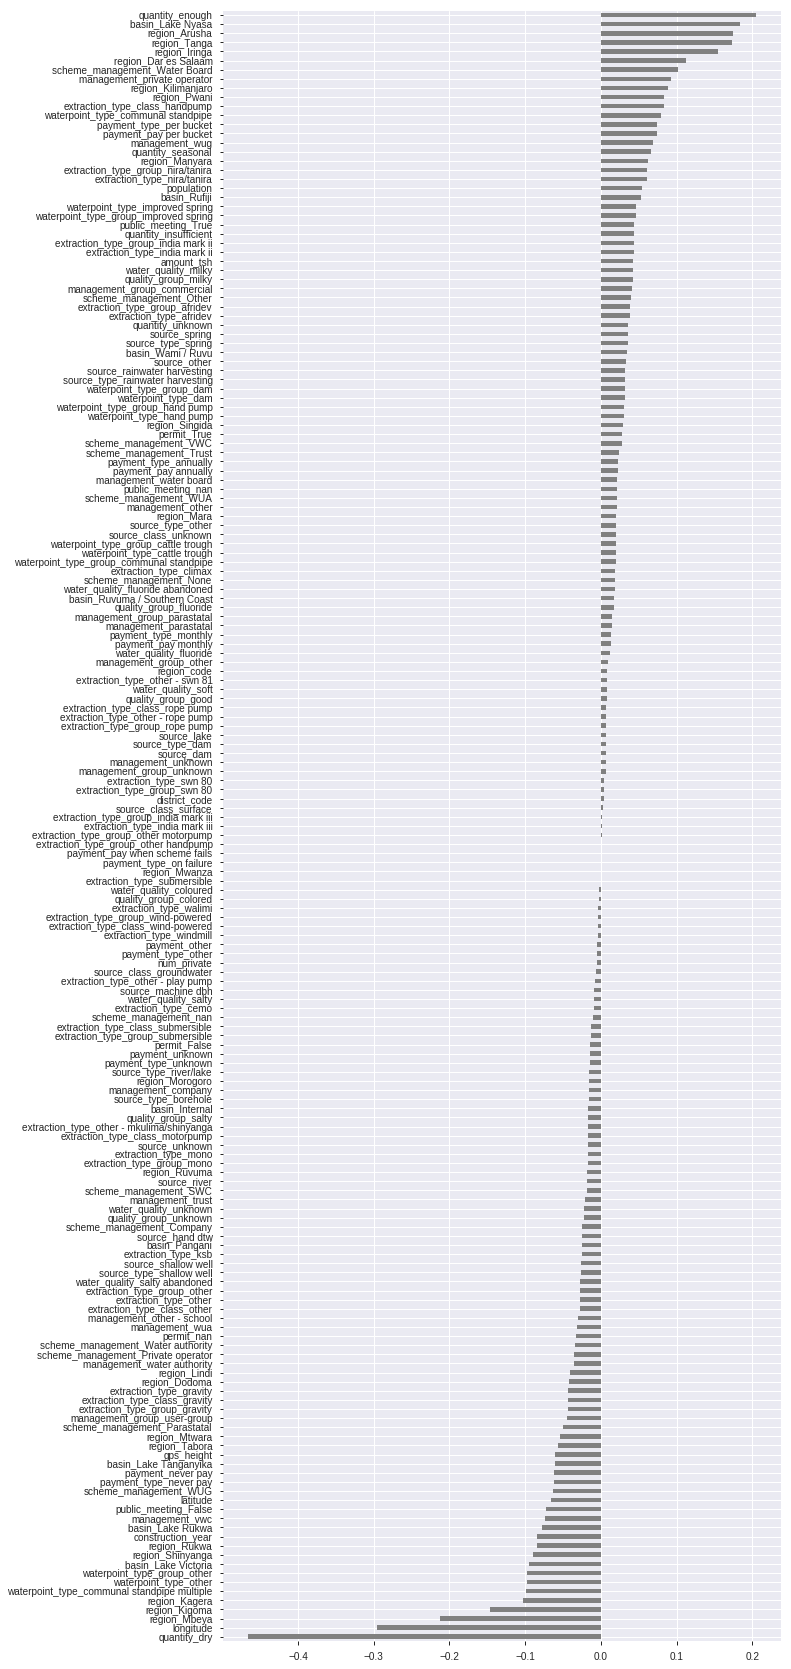

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['logisticregression']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-01.csv', index=False)

In [80]:
!head submission-01.csv

id,status_group
50785,non functional
51630,functional
17168,non functional
45559,non functional
49871,functional
52449,functional
24806,functional
28965,non functional
36301,functional


In [0]:
if in_colab:
  from google.colab import files
  files.download('submission-01.csv')